In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

lmsys_chatbot_arena_path = kagglehub.competition_download('lmsys-chatbot-arena')

print('Data source import complete.')


100%|██████████| 57.0M/57.0M [00:00<00:00, 97.6MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os

for root, dirs, files in os.walk("/root/.cache/kagglehub/"):
    for f in files:
        if f.endswith(".csv"):
            print(os.path.join(root, f))

/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/test.csv
/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/train.csv
/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/sample_submission.csv


In [ ]:
import pandas as pd
import os

# Find the extracted data path
data_path = '/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/lmsys-chatbot-arena/'

#load data
train = pd.read_csv("/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/train.csv")
test = pd.read_csv("/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/test.csv")
sample = pd.read_csv("/root/.cache/kagglehub/competitions/lmsys-chatbot-arena/sample_submission.csv")

#preview data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample.shape)

#see the first few rows
train.head()

Train shape: (57477, 9)
Test shape: (3, 4)
Sample submission shape: (3, 4)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [ ]:
#clean and combine text
def combine_text(row):
    return (
        f"Prompt: {row['prompt']}\n\n"
        f"### Response A:\n{row['response_a']}\n\n"
        f"### Response B:\n{row['response_b']}"
    )

train["text"] = train.apply(combine_text, axis=1)
test["text"] = test.apply(combine_text, axis=1)

#create target labels (0=A, 1=B, 2=Tie)
train["label"] = train[["winner_model_a", "winner_model_b", "winner_tie"]].values.argmax(axis=1)

print(train[["text", "label"]].head(2))


                                                text  label
0  Prompt: ["Is it morally right to try to have a...      0
1  Prompt: ["What is the difference between marri...      1


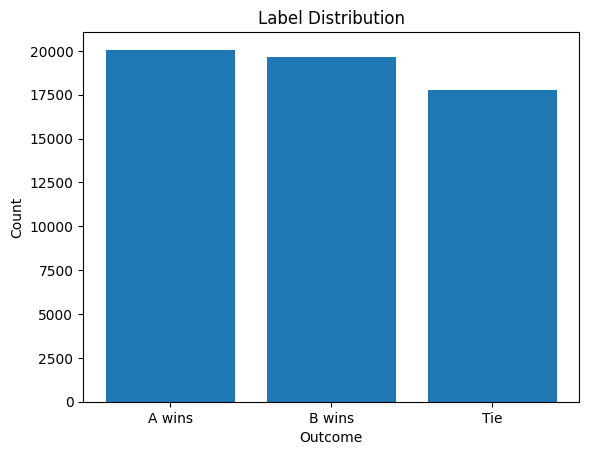

label
0    20064
1    19652
2    17761
Name: count, dtype: int64


In [ ]:
#check class distribution
import matplotlib.pyplot as plt

label_counts = train["label"].value_counts().sort_index()
label_names = ["A wins", "B wins", "Tie"]

plt.bar(label_names, label_counts)
plt.title("Label Distribution")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

print(label_counts)


In [ ]:
#baseline model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

#train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    train["text"], train["label"], test_size=0.2, random_state=42, stratify=train["label"]
)

#TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(1,3), min_df=3, max_features=200000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf  = vectorizer.transform(test["text"])

#train logistic regression
model = LogisticRegression(max_iter=2000, C=2.0, multi_class="multinomial", n_jobs=-1)
model.fit(X_train_tfidf, y_train)

#predict probabilities
valid_preds = model.predict_proba(X_valid_tfidf)
test_preds  = model.predict_proba(X_test_tfidf)

#evaluate validation performance
print("Validation Log Loss:", log_loss(y_valid, valid_preds))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Log Loss: 1.0920630275787069


In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss

lgb = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8
)

lgb.fit(X_train_tfidf, y_train)
valid_preds = lgb.predict_proba(X_valid_tfidf)
print("LightGBM Log Loss:", log_loss(y_valid, valid_preds))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 41.312220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2817042
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 32518
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Log Loss: 1.0979913282596387
